# Filecoin Plus

[Filecoin Plus](https://docs.filecoin.io/basics/how-storage-works/filecoin-plus) is based on a set of guiding principles, detailed in FIP-0003, that focus the program on increasing Filecoin’s effectiveness at becoming the decentralized storage network for humanity’s most important information.

Root key-holders, notaries, clients, and storage providers, interact through the allocation and spending of DataCap. Notaries retrieve DataCap in batches and then allocate it to trustworthy clients that spend the DataCap to fund storage deals. Storage providers that receive DataCap receive a 10x boost to their quality-adjusted power for the storage space offered in that deal, which increases their block reward share in the network. This creates a mechanism that incentivizes all participants to make Filecoin more useful.

DataCap, when allocated to a client, can be spent by the client in storage deals with storage providers. Those deals carry a higher deal quality multiplier, which increases the “quality adjusted power” of the storage provider on the network by a factor of 10, yielding better block rewards for the storage provider over time. DataCap is granted in batches to Notaries, who can allocate it to clients that spend the DataCap to fund storage deals. DataCap is consumed as it is used to make deals.

There are two APIs collecting Datacap data:
  - [Datacapstats](https://api.datacapstats.io/docs)
  - [FilPlus](https://documenter.getpostman.com/view/131998/Tzsim4NU#intro)

In [74]:
import requests
import os
import pandas as pd
import altair as alt

url = "https://api.datacapstats.io/"


Let's expore the verified clients first.

In [26]:
verified_clients = pd.DataFrame(
    requests.get(url + "api/getVerifiedClients").json()["data"]
)

# Save as CSV
# verified_clients.drop(columns=["allowanceArray"]).to_csv(
#     "verified_clients.csv", index=False
# )


How many unique verified clients are there?

In [29]:
verified_clients["addressId"].nunique()


2751

Let's dig into a random verified client, `f01917316`.

In [30]:
verified_clients[verified_clients["addressId"] == "f01917316"]


,id,addressId,address,retries,auditTrail,name,orgName,region,website,industry,initialAllowance,allowance,verifierAddressId,createdAtHeight,issueCreateTimestamp,createMessageTimestamp,verifierName,dealCount,providerCount,topProvider,receivedDatacapChange,usedDatacapChange,allowanceArray
65,2879,f01917316,f13dxmfvac3yciokh7eqy77u4wogtdga5mn7ccpsy,3,n/a,,Brazil Data Cube---Piero,,https://registry.opendata.aws/brazil-data-cubes/,,2855915482450494,1756403854674494,f02049625,2921678,NaN,1685956740,LDN v3.1 multisig,29486.0,12.0,28.99,1756403854674494,990041501335552,"[{'id': 5959, 'error': '', 'height': 2921678, ..."
518,2660,f01917316,f13dxmfvac3yciokh7eqy77u4wogtdga5mn7ccpsy,3,n/a,,Brazil Data Cube---Piero,South America,https://registry.opendata.aws/brazil-data-cubes/,Web3,109951162777600,1756403854674494,f01858410,2679464,NaN,1678690320,LDN v3 multisig,3522.0,9.0,20.13,1756403854674494,990041501335552,"[{'id': 5024, 'error': 'allocation event not f..."


We can also check their allowance history.

In [32]:
pd.json_normalize(
    verified_clients[verified_clients["addressId"] == "f01917316"][
        "allowanceArray"
    ].explode()
)


,id,error,height,msgCID,retries,addressId,allowance,auditTrail,allowanceTTD,issueCreator,usedAllowance,isLdnAllowance,isEFilAllowance,verifierAddressId,isFromAutoverifier,searchedByProposal,issueCreateTimestamp,hasRemainingAllowance,createMessageTimestamp
0,5959,,2921678,bafy2bzaceaox2m5vjmnj4ii37b4nj3dbekjex6tlm6uh6...,0,f01917316,1756403854674494,https://github.com/filecoin-project/filecoin-p...,212161.0,107857921,0,True,False,f02049625,False,True,1.662647e+09,True,1685956740
1,5879,,2901262,bafy2bzaceb36l6ncwiihb75y5br3oe6o7qji7lpxigilh...,0,f01917316,879609302220800,https://github.com/filecoin-project/filecoin-p...,89274.0,107857921,872909153239040,True,False,f02049625,False,True,1.662647e+09,True,1685344260
2,5416,"matching request event not found, uuid method",2775670,bafy2bzaceba5pp46fkzlp7ghdqiwm7yzx6nawjhlp6jrl...,0,f01917316,109951162777600,https://github.com/filecoin-project/filecoin-p...,11669441.0,107857921,109951162777600,True,False,f02049625,False,True,1.662647e+09,False,1681576500
3,5406,allocation event not found,2772850,bafy2bzacebrqacn6v2ast7omc3s7b4svik2zxjvdi7jrz...,0,f01917316,109951162777600,None,NaN,None,109951162777600,True,False,f02049625,False,True,NaN,False,1681491900
4,5024,allocation event not found,2679464,bafy2bzacedtfgponyb4mlq7qjljg6iix6j3k6asujuyd6...,0,f01917316,109951162777600,https://github.com/filecoin-project/filecoin-p...,NaN,107857921,426198194716672,True,False,f01858410,False,True,1.662647e+09,False,1678690320


Allowances are given over time.

<Axes: xlabel='issueCreateTimestamp'>

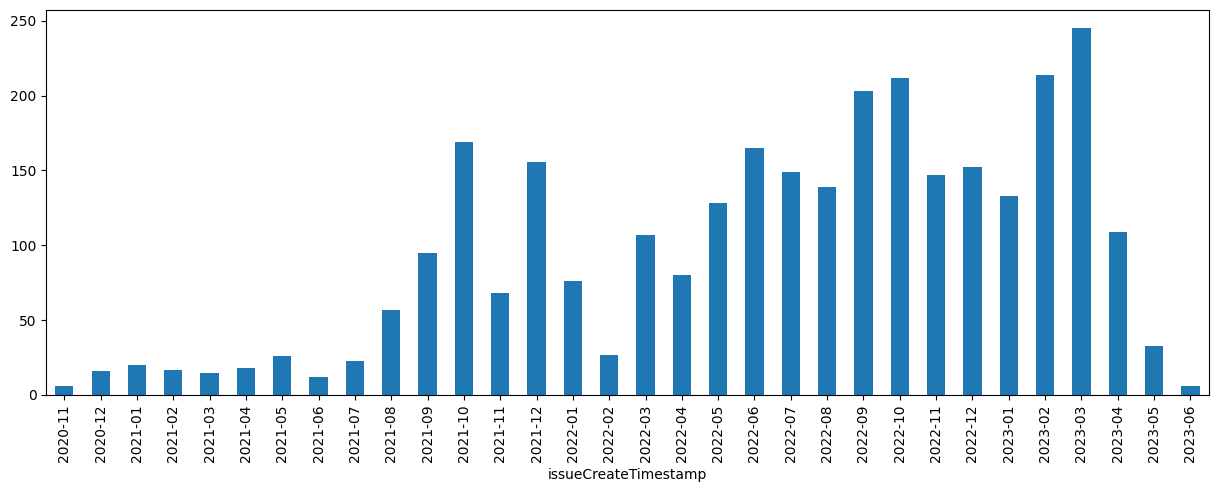

In [33]:
allowances = pd.json_normalize(verified_clients["allowanceArray"].explode())

allowances["issueCreateTimestamp"] = pd.to_datetime(
    allowances["issueCreateTimestamp"], unit="s"
)

allowances.groupby(allowances["issueCreateTimestamp"].dt.to_period("M"))[
    "id"
].count().plot(kind="bar", figsize=(15, 5))


We can also check if the API's database is missing any client that has made verified deals?

In [34]:
%load_ext sql
%sql duckdb:////tmp/database.duckdb

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [35]:
%%sql
create or replace table state_market_deals as (
    select DealID, Proposal.*, State.* from read_ndjson_auto("/tmp/ParsedStateMarketDeals.json")
)

Running query in 'duckdb:////tmp/database.duckdb'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Count
36806346


In [36]:
unique_clients = %sql select distinct Client from state_market_deals where VerifiedDeal 

Running query in 'duckdb:////tmp/database.duckdb'

In [47]:
set(unique_clients.DataFrame()["Client"].values) - set(
    verified_clients["addressId"].unique()
)


{'f01468824', 'f01468825', 'f01491417', 'f01822047', 'f01893730'}

In [ ]:
%%sql

select * from state_market_deals where Client in ('f01468824', 'f01468825', 'f01491417', 'f01822047', 'f01893730')


There are verified deals for these clients (https://filfox.info/en/deal/2852190)

## Verifiers

In [49]:
verifiers = pd.DataFrame(requests.get(url + "api/getVerifiers").json()["data"])
verifiers.head()


,id,addressId,address,auditTrail,retries,name,orgName,removed,initialAllowance,allowance,inffered,isMultisig,createdAtHeight,issueCreateTimestamp,createMessageTimestamp,verifiedClientsCount,receivedDatacapChange,allowanceArray
0,243,f02049625,f2yk6skf7mpk5mkp3bk5qyy5pmxgic6hfp55z2wcq,n/a,3,LDN v3.1 multisig,Filecoin Plus Program,False,675242724122353900,99956107300883651,False,True,2909834,NaN,1685601420,330,196857661348642800,"[{'id': 476, 'error': '', 'height': 2909834, '..."
1,247,f02145144,f1afp3ga3fa6jutkkjdm63uecaapxjttvlf4ylw4i,n/a,3,None,None,False,68719476736,68719476736,False,False,2807164,NaN,1682521320,0,0,"[{'id': 474, 'error': '', 'height': 2807164, '..."
2,246,f02145137,f1eper7jfxbc5pq7ubhh5wyshzy6iwaarsppw5oza,n/a,3,None,None,False,68719476736,68719476736,False,False,2807163,NaN,1682521290,0,0,"[{'id': 473, 'error': '', 'height': 2807163, '..."
3,245,f02130581,f1xqc6b7dcm3iksnvkf3tlakklr2atxrvulfpha7i,n/a,3,None,None,False,68719476736,68719476736,False,False,2791492,NaN,1682051160,0,0,"[{'id': 472, 'error': '', 'height': 2791492, '..."
4,244,f02131432,f1fpaa5nemr4xxgcxkanh5dizozaqmljquujyfnmi,n/a,3,None,None,False,68719476736,68719476736,False,False,2791489,NaN,1682051070,0,0,"[{'id': 471, 'error': '', 'height': 2791489, '..."


In [50]:
verifiers["addressId"].nunique()


247

In [12]:
# verified_deals_response = requests.get(url + "api/getVerifiedDeals")
# verified_deals = pd.DataFrame()
# verified_deals.head(5)


## Storage Providers

In [58]:
storage_providers = pd.DataFrame(requests.get(url + "api/getMiners").json()["data"])
storage_providers.sort_values(by="noOfDeals", ascending=False).head(5)


,id,provider,noOfDeals,noOfClients,avgDealLength,avgDealPrice,minDealSize,noOfVerifiedDeals,percentOfVerifiedDealsFromRawPower,verifiedDealsTotalSize,rawPower
1094,362,f01131460,94926.0,4.0,37725990,0,1024,162722.0,12.0,234987671519232,1749185560838144
1584,1121,f010254,81071.0,2.0,46062780,0,134217728,63899.0,0.0,69675643830272,3308911524315136
1769,276,f01128320,71787.0,3.0,35758230,0,256,196991.0,11.0,315021553827840,2439438344912896
1067,363,f01264125,39123.0,4.0,45721380,0,1048576,34581.0,0.0,223541851062272,26096049491804160
894,1182,f022352,32816.0,95.0,43667100,2454,1048576,81485.0,93.0,2160946129666048,1826460612427776


In [80]:
storage_providers["rawPowerTiBs"] = (
    storage_providers["rawPower"].fillna(0).astype(int) / 1024**5
)


In [86]:
alt.Chart(storage_providers[storage_providers["rawPowerTiBs"] < 1]).mark_bar().encode(
    alt.X("rawPowerTiBs", bin=alt.Bin(maxbins=200)),
    y="count()",
    tooltip=["count()", "rawPowerTiBs"],
).properties(width="container")


alt.Chart(...)

Seems the stats might be off or I'm not filtering correctly.


In [ ]:
# Other endpoint for usage
# requests.get(url + "api/getVerifiedClientsDatacapUsage").json()


<Axes: title={'center': 'Monthly Datacap Request'}, xlabel='day'>

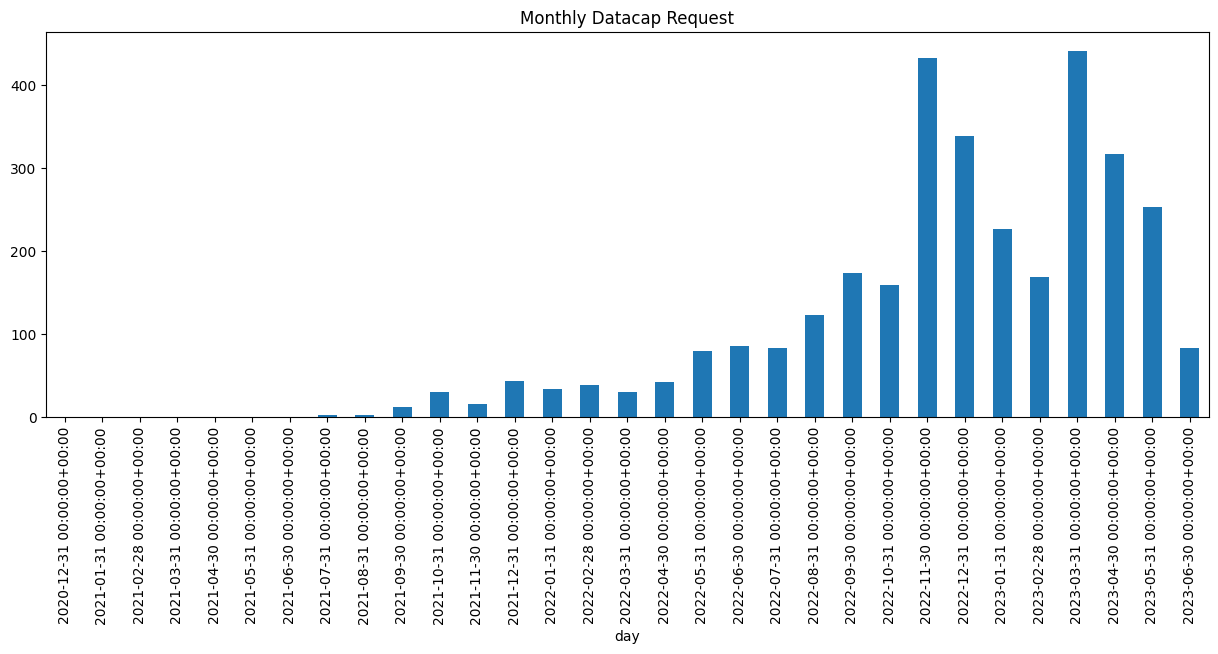

In [87]:
dc_requested = pd.DataFrame(
    requests.get(
        "https://api.datacapstats.io/api/timescale/get-dc-requested/per-day"
    ).json()
)
# Parse day column to datetime and dcRequests to int
dc_requested["day"] = pd.to_datetime(dc_requested["day"])
dc_requested["dcRequests"] = dc_requested["dcRequests"].astype(int)

# Monthly datacap requested
dc_requested.groupby(pd.Grouper(key="day", freq="M"))["dcRequests"].sum().plot(
    kind="bar", figsize=(15, 5), title="Monthly Datacap Request"
)


In [115]:
allowance_historic_data = pd.DataFrame(
    requests.get(url + "api/getAllowanceHistoricData").json()
)
# Cast allowance to int and allowanceTimestamp to datetime
allowance_historic_data["allowance_pibs"] = (
    allowance_historic_data["allowance"].astype(int) / 1024**5
)
allowance_historic_data["allowanceTimestamp"] = pd.to_datetime(
    allowance_historic_data["allowanceTimestamp"]
)

# Monthly allowance (thicker bars)
alt.Chart(allowance_historic_data).mark_bar().encode(
    alt.X("allowanceTimestamp:T"),
    y="sum(allowance_pibs)",
    tooltip=["sum(allowance_pibs)"],
).properties(width="container")


alt.Chart(...)

Using Filplus API now

In [116]:
url = "https://api.filplus.d.interplanetary.one/public/"
headers = {"x-api-key": os.getenv("FILPLUS_API_KEY")}

# response = requests.request("GET", url, headers=headers)

# requests.get(url + "public/api/getApiKey").json()
# api/getLdnAllowances?page=1&limit=200"


In [ ]:
ldn_allowances = pd.DataFrame(
    requests.get(
        url + "api/getLdnAllowances?page=1&limit=5500",
        headers=headers,
    ).json()["data"]
)

ldn_allowances["timestamp"] = pd.to_datetime(ldn_allowances["timestamp"], unit="s")


In [ ]:
ldn_allowances


<Axes: title={'center': 'Monthly LDN Allowances'}, xlabel='timestamp', ylabel='Allowances'>

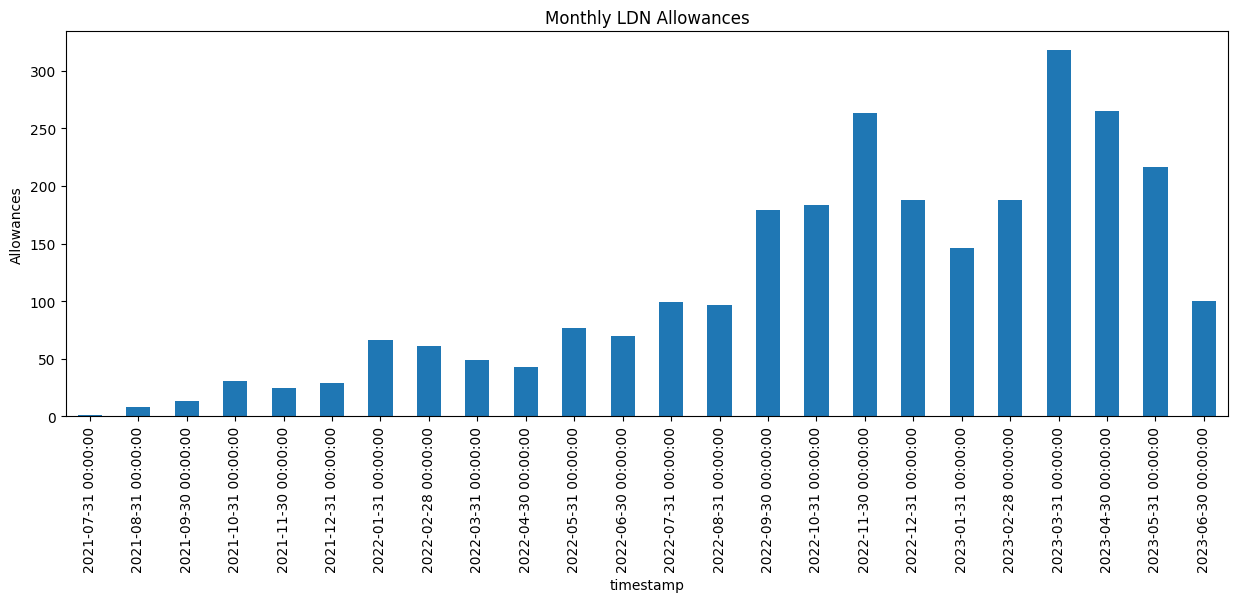

In [65]:
# count allowance by day
ldn_allowances["day"] = ldn_allowances["timestamp"].dt.date

# Plot monthly allowance
ldn_allowances.groupby(pd.Grouper(key="timestamp", freq="M"))[
    "allowanceId"
].count().plot(
    kind="bar", figsize=(15, 5), title="Monthly LDN Allowances", ylabel="Allowances"
)


In [1]:
# Notaries from "https://raw.githubusercontent.com/keyko-io/filecoin-content/main/json/prod/verifiers-registry.json"
